In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
import tempfile
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]
IMAGE_RESIZE = [256, 256]

In [3]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec'),
    test_size=0.1, random_state=42
)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
print('Train TFRecord Files:', len(TRAINING_FILENAMES))
print('Validation TFRecord Files:', len(VALID_FILENAMES))
print('Test TFRecord Files:', len(TEST_FILENAMES))

Train TFRecord Files: 14
Validation TFRecord Files: 2
Test TFRecord Files: 16


In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [5]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [17]:
# def augmentation_pipeline(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.resize(image, IMAGE_RESIZE)
#     return image, label

def augmentation_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.resize(image, IMAGE_RESIZE)
    return image, label


In [18]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(augmentation_pipeline, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [19]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [20]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [21]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [22]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(
    'Dataset: {} training images, {} validation images, {} unlabeled test images'.format(
        NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES
    )
)

Dataset: 28984 training images, 4142 validation images, 10982 unlabeled test images


In [23]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [24]:
train_csv = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_csv = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

In [25]:
total_img = train_csv['target'].size

malignant = np.count_nonzero(train_csv['target'])
benign = total_img - malignant

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_img, malignant, 100 * malignant / total_img))

Examples:
    Total: 33126
    Positive: 584 (1.76% of total)



In [26]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [27]:
image_batch, label_batch = next(iter(train_dataset))

In [28]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")

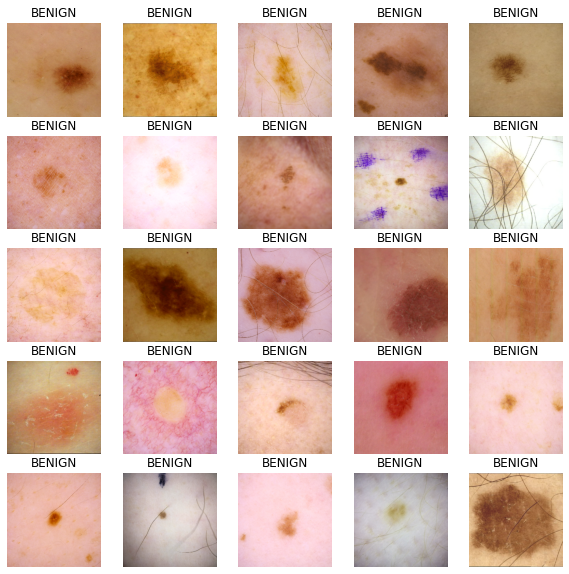

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [30]:
def make_model(output_bias = None, metrics = None):    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    base_model = tf.keras.applications.Xception(input_shape=(*IMAGE_RESIZE, 3),
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid',
                              bias_initializer=output_bias)
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model

In [31]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [32]:
initial_bias = np.log([malignant/benign])
initial_bias

array([-4.02038586])

In [33]:
weight_for_0 = (1 / benign)*(total_img)/2.0 
weight_for_1 = (1 / malignant)*(total_img)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 28.36


In [34]:
with strategy.scope():
    model = make_model(output_bias = initial_bias, metrics=tf.keras.metrics.AUC(name='auc'))

83689472/83683744 [==============================] - 1s 0us/step


In [35]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("melanoma_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [36]:
history = model.fit(
    train_dataset, epochs=50,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps=VALID_STEPS,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    class_weight=class_weight
)

Epoch 1/50
226/226 [==============================] - 111s 489ms/step - auc: 0.7695 - loss: 0.6257 - val_auc: 0.7666 - val_loss: 0.1707 - lr: 0.0100
Epoch 2/50
226/226 [==============================] - 85s 376ms/step - auc: 0.8299 - loss: 0.5186 - val_auc: 0.7459 - val_loss: 0.2433 - lr: 0.0089
Epoch 3/50
226/226 [==============================] - 88s 391ms/step - auc: 0.8619 - loss: 0.4624 - val_auc: 0.7823 - val_loss: 0.2042 - lr: 0.0079
Epoch 4/50
226/226 [==============================] - 89s 392ms/step - auc: 0.8701 - loss: 0.4548 - val_auc: 0.7374 - val_loss: 0.2326 - lr: 0.0071
Epoch 5/50
226/226 [==============================] - 90s 400ms/step - auc: 0.8816 - loss: 0.4407 - val_auc: 0.7658 - val_loss: 0.2815 - lr: 0.0063
Epoch 6/50
226/226 [==============================] - 77s 341ms/step - auc: 0.8966 - loss: 0.4024 - val_auc: 0.7576 - val_loss: 0.1910 - lr: 0.0056
Epoch 7/50
226/226 [==============================] - 77s 342ms/step - auc: 0.9031 - loss: 0.3951 - val_auc: 0.

In [37]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)

Computing predictions...


In [38]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
sub.head()

image_name  target
0  ISIC_0052060       0
1  ISIC_0052349       0
2  ISIC_0058510       0
3  ISIC_0073313       0
4  ISIC_0073502       0

In [39]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

Generating submission.csv file...


In [40]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

image_name    target
0  ISIC_6381819  0.019488
1  ISIC_5583376  0.046445
2  ISIC_6408546  0.010290
3  ISIC_6932354  0.030297
4  ISIC_8191278  0.016548

In [41]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('sub1.csv', index=False)
sub.head()

image_name    target
0  ISIC_0052060  0.016348
1  ISIC_0052349  0.003745
2  ISIC_0058510  0.001291
3  ISIC_0073313  0.006613
4  ISIC_0073502  0.007501